<a href="https://colab.research.google.com/github/mehrotrasan16/CS581-CAN-DO-Project/blob/sanketm-lstm-experiments/code/LSTM_CAN_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from numpy import load
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


# Load Datasets

In [10]:
freedf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Attack_free_dataset.csv')
freedf['label'] = 1
freedf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0.000000,790,0,8,5,32,234,10,32,26,0,127,1
1,0.000224,809,0,8,215,167,127,140,17,47,0,16,1
2,0.000462,128,0,8,0,23,234,10,32,26,32,67,1
3,0.000704,129,0,8,127,132,96,0,0,0,0,83,1
4,0.000878,288,0,4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2369393,1037.589395,68,0,8,0,0,0,255,111,0,0,0,1
2369394,1037.589628,357,0,8,17,232,127,0,0,0,12,138,1
2369395,1037.589812,688,0,5,35,0,0,7,172,0,0,0,1
2369396,1037.590065,1200,0,8,0,0,0,0,0,0,0,0,1


In [11]:
freedf.groupby('label').count()

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,,
1,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398


In [12]:
dosdf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/DoS_attack_dataset.csv')
dosdf['label'] = np.where(dosdf['CAN ID'] == 0,1,0)
dosdf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0.000000,0,0,8,0,0,0,0,0,0,0,0,1
1,0.000271,128,0,8,0,23,220,9,22,17,22,187,0
2,0.000495,0,0,8,0,0,0,0,0,0,0,0,1
3,0.000736,129,0,8,64,132,135,0,0,0,0,107,0
4,0.000983,0,0,8,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
656574,306.295869,0,0,8,0,0,0,0,0,0,0,0,1
656575,306.296118,129,0,8,64,132,137,0,0,0,0,240,0
656576,306.296365,0,0,8,0,0,0,0,0,0,0,0,1
656577,306.296624,399,0,8,0,59,24,0,0,63,0,0,0


In [13]:
dosdf.groupby('label').count()

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,,
0,320955,320955,320955,320955,320955,320955,320955,320955,320955,320955,320955,320955
1,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624


In [14]:
impersonatedf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Impersonation_attack_dataset.csv')
start_time=impersonatedf['Timestamp'][0]
impersonatedf['Timestamp'] = impersonatedf['Timestamp'] - start_time
impersonatedf['label'] = np.where(impersonatedf['CAN ID'] == 356,1,0) 
impersonatedf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0.000000,1415,0,8,0,0,0,0,0,0,0,1,0
1,0.000777,790,0,8,5,28,106,10,28,19,0,127,0
2,0.001015,399,0,8,0,33,28,0,0,67,0,0,0
3,0.001247,608,0,8,5,28,0,48,255,147,99,53,0
4,0.001487,128,0,8,0,23,106,10,28,19,28,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995467,482.648772,1508,0,3,0,2,0,0,0,0,0,0,0
995468,482.648988,339,0,8,0,128,16,255,0,255,160,46,0
995469,482.649224,357,0,8,14,216,127,0,0,0,3,170,0
995470,482.649460,544,0,8,244,3,247,3,12,0,58,16,0


In [15]:
print(int('0x164',base=16))
impersonatedf.groupby('label').count()

356


,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,,
0,938000,938000,938000,938000,938000,938000,938000,938000,938000,938000,938000,938000
1,57472,57472,57472,57472,57472,57472,57472,57472,57472,57472,57472,57472


In [16]:
impersonatedf.loc[impersonatedf['Timestamp'] > impersonatedf['Timestamp'][0]  + 250].loc[impersonatedf['CAN ID'] == 356]

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
515588,250.001543,356,100,8,1,2,3,4,5,6,7,8,1
515589,250.001798,356,0,8,0,8,0,0,0,0,10,2,1
515605,250.007007,356,0,8,0,8,0,0,0,0,11,3,1
515630,250.017030,356,0,8,0,8,0,0,0,0,12,4,1
515650,250.026953,356,0,8,0,8,0,0,0,0,13,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995380,482.604350,356,0,8,0,8,0,0,0,0,0,8,1
995402,482.614275,356,0,8,0,8,0,0,0,0,1,9,1
995426,482.624298,356,0,8,0,8,0,0,0,0,2,10,1
995444,482.634225,356,0,8,0,8,0,0,0,0,3,11,1


In [17]:
27673/995472

0.02779887329829468

The above dataset is super biased, with anomalies making up for only 2% of the data. On merging this with the Attack-free dataset, this ratio will only get smaller, we will have 

In [18]:
fuzzydf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Fuzzy_attack_dataset.csv')
fuzzydf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
0,0.000000,544,0,8,41,197,38,85,106,103,2,93
1,0.000868,1201,0,8,94,81,207,183,76,153,170,151
2,0.001212,688,0,5,58,255,0,7,44,0,0,0
3,0.001452,357,0,8,0,8,128,2,0,0,12,134
4,0.001782,544,0,8,212,166,227,169,35,170,211,31
...,...,...,...,...,...,...,...,...,...,...,...,...
591985,347.330224,339,0,8,0,161,32,255,0,255,32,223
591986,347.330461,544,0,8,192,3,245,3,12,0,71,16
591987,347.330678,1440,0,8,166,32,82,109,167,238,124,226
591988,347.331050,1442,0,8,238,34,248,11,91,131,153,171


IN the above datasets, we have also added labels where possible, to try a supervised learning experiment.

# Attack - Free Dataset

This is a trivial experiment being conducted on the attack-free state network dataset. All the labels in this dataset are set to 1.

Think of this as a sort of pre-training model dataset. i.e. This dataset contains no attacks and a model can be trained on it to learn what normal network traffic looks like.



## Vanilla LSTM

### Train-test split

In [ ]:
series = freedf.to_numpy()
series = series[ : , :, np.newaxis] 

In [ ]:
series.shape

(2369398, 13, 1)

In [ ]:
n_features = series.shape[1]
train_split = int(series.shape[0]*0.7)
print(f'train split : {train_split}')

val_split = int(series.shape[0]*0.8)

X_train, y_train = series[:train_split, :n_features-1], series[:train_split, -1] # -1 references the last column
X_valid, y_valid = series[train_split:val_split, :n_features-1], series[train_split:val_split, -1]
X_test, y_test = series[val_split:, :n_features-1], series[val_split:, -1]


train split : 1658578


In [ ]:
X_train.shape, y_train.shape

((1658578, 12, 1), (1658578, 1))

In [ ]:
X_valid.shape,y_valid.shape

((236940, 12, 1), (236940, 1))

In [ ]:
X_test.shape, y_test.shape

((473880, 12, 1), (473880, 1))

In [ ]:
X_train[20],y_train[20]

(array([[5.713e-03],
        [3.570e+02],
        [0.000e+00],
        [8.000e+00],
        [1.500e+01],
        [2.320e+02],
        [1.270e+02],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [1.520e+02]]), array([1.]))

### Vanilla LSTM Model

In [ ]:
rnnmodel = keras.models.Sequential([
    keras.layers.LSTM(100,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='relu')
])
rnnmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print(rnnmodel.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
None


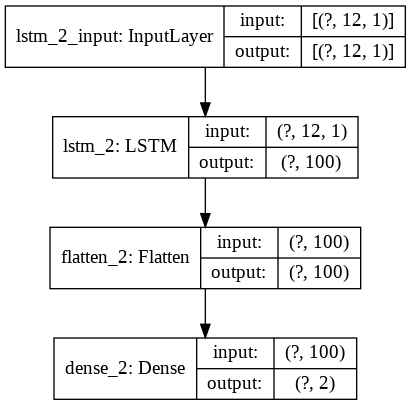

In [ ]:
tf.keras.utils.plot_model(rnnmodel,show_shapes=True)

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

rnnhistory = rnnmodel.fit(X_train,y_train,validation_data=(X_valid,y_valid),
                          epochs=5,
                          batch_size=1028,
                          callbacks=[early_stop])

Epoch 1/5
 329/1614 [=====>........................] - ETA: 6s - loss: 0.0196 - accuracy: 0.9759

KeyboardInterrupt: ignored

### Evaluation and plotting


In [ ]:
scores = rnnmodel.evaluate(X_test,y_test)
print(f"Accuracy: {scores[1]}")

14809/14809 [==============================] - 35s 2ms/step - loss: 1.1921e-07 - accuracy: 1.0000
Accuracy: 1.0


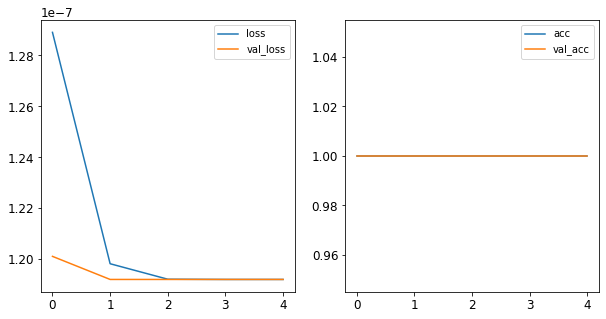

In [ ]:
plt.subplot(1,2,1)
plt.plot(rnnhistory.history["loss"])
plt.plot(rnnhistory.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(rnnhistory.history["accuracy"])
plt.plot(rnnhistory.history["val_accuracy"])
plt.legend(('acc','val_acc'))

plt.gcf().set_size_inches((10,5))
plt.show()

In [ ]:
y_pred = rnnmodel.predict(X_test)

In [ ]:
X_test[30],y_test[30], np.argmax(y_pred[30])

(array([[830.082247],
        [129.      ],
        [  0.      ],
        [  8.      ],
        [127.      ],
        [132.      ],
        [109.      ],
        [  0.      ],
        [  0.      ],
        [  0.      ],
        [  0.      ],
        [131.      ]]), array([1.]), 1)

### Saving and Checking the size of the Model

In [ ]:
saved_model_dir = '/content/drive/MyDrive/Colab Notebooks/CS581/project-data/'
rnnmodel.save(saved_model_dir + "lstm-attackfree.h5",include_optimizer=False)
print(f"Saving Model to: {saved_model_dir}lstm-attackfree.h5")

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/lstm-attackfree.h5


In [ ]:
print(f'Size of the model without compression: {os.path.getsize(saved_model_dir + "lstm-attackfree.h5")/float(2**20)} Mb')

Size of the model without compression: 0.1733551025390625 Mb


## Single Class LSTM Model

This is a trivial experiment being conducted on the attack-free state network dataset. Again, All the labels in this dataset are set to 1 and the model that's trained on this data is saved and later we try to load it to as a pretrained model to test on DoS data.

In [ ]:
X_train.shape, y_train.shape

((1658578, 12, 1), (1658578, 1))

In [ ]:
X_valid.shape,y_valid.shape

((236940, 12, 1), (236940, 1))

In [ ]:
X_test.shape, y_test.shape

((473880, 12, 1), (473880, 1))

### Modifying the vanilla LSTM

In [ ]:
rnnmodel_singleclass = keras.models.Sequential([
    keras.layers.LSTM(100,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])
rnnmodel_singleclass.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
print(rnnmodel_singleclass.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


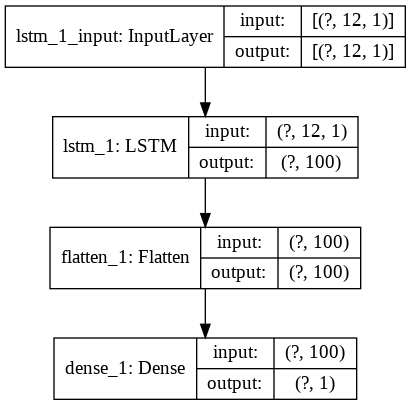

In [ ]:
tf.keras.utils.plot_model(rnnmodel_singleclass,show_shapes=True)

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
rnnhistory_singleClass = rnnmodel_singleclass.fit(X_train,y_train,
                                                  validation_data=(X_valid,y_valid),
                                                  epochs=3,
                                                  batch_size=1028,
                                                  callbacks=[early_stop]
                                                  )

Epoch 1/3
1614/1614 [==============================] - 8s 5ms/step - loss: 2.7672e-05 - accuracy: 1.0000 - val_loss: 7.9138e-06 - val_accuracy: 1.0000
Epoch 2/3
1614/1614 [==============================] - 8s 5ms/step - loss: 4.4195e-06 - accuracy: 1.0000 - val_loss: 2.1733e-06 - val_accuracy: 1.0000
Epoch 3/3
1614/1614 [==============================] - 8s 5ms/step - loss: 1.4402e-06 - accuracy: 1.0000 - val_loss: 8.8973e-07 - val_accuracy: 1.0000


### Evaluation and plotting

In [ ]:
scores = rnnmodel_singleclass.evaluate(X_test,y_test)
print(f"Accuracy: {scores[1]}")

14809/14809 [==============================] - 34s 2ms/step - loss: 9.0769e-07 - accuracy: 1.0000
Accuracy: 1.0


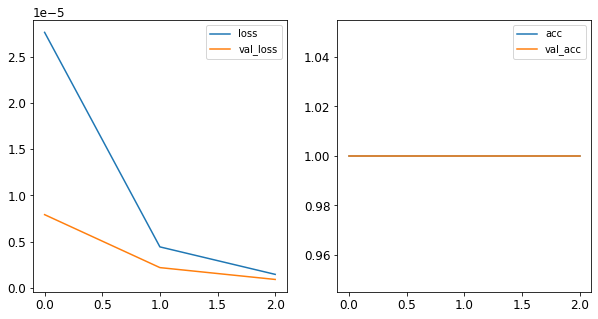

In [ ]:
plt.subplot(1,2,1)
plt.plot(rnnhistory_singleClass.history["loss"])
plt.plot(rnnhistory_singleClass.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(rnnhistory_singleClass.history["accuracy"])
plt.plot(rnnhistory_singleClass.history["val_accuracy"])
plt.legend(('acc','val_acc'))


plt.gcf().set_size_inches((10,5))
plt.show()

In [ ]:
y_pred = rnnmodel_singleclass.predict(X_test)
# plot_series(X_test[15, :, 0], y_test[15, 0], y_pred[15, 0])
# plt.show()

In [ ]:
y_pred

array([[0.99999833],
       [0.9999994 ],
       [0.99999964],
       ...,
       [0.99999964],
       [0.99999964],
       [0.99999964]], dtype=float32)

In [ ]:
y_test

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

### Saving and Checking the size of the Model

In [ ]:
saved_model_dir = '/content/drive/MyDrive/Colab Notebooks/CS581/project-data/'
rnnmodel_singleclass.save(saved_model_dir  + 'lstm-attackfree-singleclass.h5',include_optimizer=False)
print(f"Saving Model to: {saved_model_dir}lstm-attackfree-singleclass.h5")

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/lstm-attackfree-singleclass.h5


In [ ]:
print(f'Size of the model without compression: {os.path.getsize(saved_model_dir + "lstm-attackfree-singleclass.h5")/float(2**20)} Mb')

Size of the model without compression: 0.17166900634765625 Mb


## Seq2Seq - 2
Ref: https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Attack_free_dataset.csv')
df

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
0,0.000000,790,0,8,5,32,234,10,32,26,0,127
1,0.000224,809,0,8,215,167,127,140,17,47,0,16
2,0.000462,128,0,8,0,23,234,10,32,26,32,67
3,0.000704,129,0,8,127,132,96,0,0,0,0,83
4,0.000878,288,0,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2369393,1037.589395,68,0,8,0,0,0,255,111,0,0,0
2369394,1037.589628,357,0,8,17,232,127,0,0,0,12,138
2369395,1037.589812,688,0,5,35,0,0,7,172,0,0,0
2369396,1037.590065,1200,0,8,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data/JNJ.csv')
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

In [ ]:
# series2 = df.to_numpy()
# series2 = series2[ : , :, np.newaxis] 

In [ ]:
# X_train, y_train = series2[:train_split, :n_features-1], series2[:train_split, -1] # -1 references the last column
# X_valid, y_valid = series2[train_split:val_split, :n_features-1], series2[train_split:val_split, -1]
# X_test, y_test = series2[val_split:, :n_features-1], series2[val_split:, -1]

In [ ]:
# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((1658578, 12, 1),
 (1658578, 1),
 (236940, 12, 1),
 (236940, 1),
 (473880, 12, 1),
 (473880, 1))

## Treat it as a Seq2Seq problem

* Take one whole signal in - 12 features, one timestep. predict the next 3 values.
* Take  3 signals in - predict next 3 timesteps.


In [ ]:
df.shape,
train_split = int(df.shape[0]*0.7)
val_split = int(df.shape[0]*0.8)

In [ ]:
df.columns

Index(['Timestamp', 'CAN ID', 'RTR', 'DLC', 'Data1', 'Data2', 'Data3', 'Data4',
       'Data5', 'Data6', 'Data7', 'Data8', 'label'],
      dtype='object')

In [ ]:
x_train = df.iloc[:train_split,:]
x_train = x_train.drop(columns=[x for x in df.columns if x not in ['Timestamp','CAN ID', 'RTR', 'DLC']])
x_train

,Timestamp,CAN ID,RTR,DLC
0,0.000000,790,0,8
1,0.000224,809,0,8
2,0.000462,128,0,8
3,0.000704,129,0,8
4,0.000878,288,0,4
...,...,...,...,...
1658573,726.302874,672,0,8
1658574,726.303059,688,0,5
1658575,726.303298,809,0,8
1658576,726.303543,880,0,8


In [ ]:
x_train.dtypes

Timestamp    float64
CAN ID         int64
RTR            int64
DLC            int64
dtype: object

In [ ]:
# x_train = y_train.shift(1)
y_train = x_train.shift(-1)
y_train.iloc[-1] = df.iloc[train_split+1]
y_train

,Timestamp,CAN ID,RTR,DLC
0,0.000224,809.0,0.0,8.0
1,0.000462,128.0,0.0,8.0
2,0.000704,129.0,0.0,8.0
3,0.000878,288.0,0.0,4.0
4,0.001115,339.0,0.0,8.0
...,...,...,...,...
1658573,726.303059,688.0,0.0,5.0
1658574,726.303298,809.0,0.0,8.0
1658575,726.303543,880.0,0.0,8.0
1658576,726.303791,898.0,0.0,8.0


In [ ]:
df.iloc[len(df)-1]

Timestamp    1037.590316
CAN ID        356.000000
RTR             0.000000
DLC             8.000000
Data1           0.000000
Data2           8.000000
Data3           0.000000
Data4           0.000000
Data5           0.000000
Data6           0.000000
Data7           8.000000
Data8           0.000000
label           1.000000
Name: 2369397, dtype: float64

In [ ]:
x_valid =  df.iloc[train_split:val_split,:]
x_valid = x_valid.drop(columns=[x for x in df.columns if x not in ['Timestamp','CAN ID', 'RTR', 'DLC']])
y_valid = x_valid.shift(-1)
y_valid.iloc[-1] = df.iloc[val_split+1,:]

x_test =  df.iloc[val_split:len(df) - 2,:]
x_test = x_test.drop(columns=[x for x in df.columns if x not in ['Timestamp','CAN ID', 'RTR', 'DLC']])
y_test = x_test.shift(-1)
y_test.iloc[-1] = df.iloc[len(df) - 1,:]

In [ ]:
for ds in [x_train ,
x_test ,
x_valid ,
y_train ,
y_test ,
y_valid ]:
    print(ds.shape)

(1658578, 4)
(473878, 4)
(236940, 4)
(1658578, 4)
(473878, 4)
(236940, 4)


#### df to numpy to restructure into 3D

In [ ]:
def df_to_numpy(df):
    df = df.to_numpy()[:,:,np.newaxis]
    return df


In [ ]:
x_train = df_to_numpy(x_train)
x_test = df_to_numpy(x_test)
x_valid = df_to_numpy(x_valid)
y_train = df_to_numpy(y_train)
y_test = df_to_numpy(y_test)
y_valid = df_to_numpy(y_valid)

In [ ]:
for ds in [x_train ,
x_test ,
x_valid ,
y_train ,
y_test ,
y_valid ]:
    print(ds.shape)

(1658578, 4, 1)
(473878, 4, 1)
(236940, 4, 1)
(1658578, 4, 1)
(473878, 4, 1)
(236940, 4, 1)


In [ ]:
mse = tf.keras.losses.MeanSquaredError()
mse(y_true, y_).numpy()

In [ ]:
def myloss(ytrue,ypred):
    diff = tf.math.abs(tf.math.subtract(ytrue, ypred))
    return tf.math.reduce_sum(diff)

In [ ]:
#####################################
#Before do anything else do not forget to reset the backend for the next iteration (rerun the model)
tf.keras.backend.clear_session()

seq_rnnmodel = keras.models.Sequential([
    keras.layers.Input(batch_shape=(x_train.shape[1],10,16)),
    keras.layers.LSTM(100),
    keras.layers.Flatten(),
    keras.layers.Dense(y_train.shape[1], activation='relu')
])
seq_rnnmodel.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])
print(seq_rnnmodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (4, 100)                  46800     
_________________________________________________________________
flatten (Flatten)            (4, 100)                  0         
_________________________________________________________________
dense (Dense)                (4, 4)                    404       
Total params: 47,204
Trainable params: 47,204
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
seq_rnnhistory = seq_rnnmodel.fit(x_train,y_train,validation_data=(x_valid,y_valid),epochs=5, batch_size=1028)

Epoch 1/5


ValueError: ignored

In [ ]:
scores = seq_rnnmodel.evaluate(x_test,y_test)
print(f"Accuracy: {scores[1]}")

13089/14809 [=========================>....] - ETA: 3s - loss: 243241.8750 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

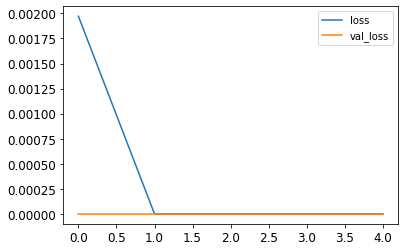

In [ ]:
plt.plot(seq_rnnhistory.history["loss"])
plt.plot(seq_rnnhistory.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.show()

In [ ]:
y_pred = seq_rnnhistory.predict(X_test)
# plot_series(X_test[15, :, 0], y_test[15, 0], y_pred[15, 0])
# plt.show()

NameError: ignored

In [ ]:
predlist = np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))])
predlist = predlist.reshape((predlist.shape[0],1))
y_test.shape, y_pred.shape, predlist.shape

((236941, 1), (236941, 2), (236941, 1))

In [ ]:
compdf = pd.DataFrame(predlist)
compdf['real'] = y_test
compdf = compdf.rename(columns={0:'pred'})
compdf['right label'] = np.where(compdf['pred'] == compdf['real'],True, False)
compdf

,pred,real,right label
0,1,1,True
1,1,1,True
2,1,1,True
3,1,1,True
4,1,1,True
...,...,...,...
236936,1,1,True
236937,1,1,True
236938,1,1,True
236939,1,1,True


# DoS attack Dataset

In [ ]:
dosdf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0.000000,0,0,8,0,0,0,0,0,0,0,0,1
1,0.000271,128,0,8,0,23,220,9,22,17,22,187,0
2,0.000495,0,0,8,0,0,0,0,0,0,0,0,1
3,0.000736,129,0,8,64,132,135,0,0,0,0,107,0
4,0.000983,0,0,8,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
656574,306.295869,0,0,8,0,0,0,0,0,0,0,0,1
656575,306.296118,129,0,8,64,132,137,0,0,0,0,240,0
656576,306.296365,0,0,8,0,0,0,0,0,0,0,0,1
656577,306.296624,399,0,8,0,59,24,0,0,63,0,0,0


In [ ]:
dosdf.groupby('label').count()

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,,
0,320955,320955,320955,320955,320955,320955,320955,320955,320955,320955,320955,320955
1,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624


### Train-test split

In [ ]:
dosdf.shape

(656579, 13)

In [ ]:
train_split = int(dosdf.shape[0]*0.7)
val_split = int(dosdf.shape[0]*0.1) + train_split
#test is val_split: 
train_split, val_split

(459605, 525262)

In [ ]:
dosseries = dosdf.to_numpy()
dosseries = dosseries[ : , :, np.newaxis] 

In [ ]:
dosseries.shape

(656579, 13, 1)

In [ ]:
n_features = dosseries.shape[1]

X_train, y_train = dosseries[:train_split, :n_features-1], dosseries[:train_split, -1] # -1 references the last column
X_valid, y_valid = dosseries[train_split:val_split, :n_features-1], dosseries[train_split:val_split, -1]
X_test, y_test = dosseries[val_split:, :n_features-1], dosseries[val_split:, -1]


### Vanilla LSTM Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
rnnDosmodel = keras.models.Sequential([
    keras.layers.LSTM(100,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='relu')
])
rnnDosmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print(rnnDosmodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
None


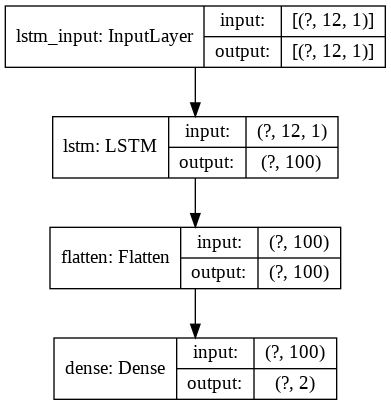

In [ ]:
tf.keras.utils.plot_model(rnnDosmodel,show_shapes=True)

In [ ]:
rnnhistory = rnnDosmodel.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=5, batch_size=1028)

Epoch 1/5
448/448 [==============================] - 3s 6ms/step - loss: 0.2781 - accuracy: 0.7518 - val_loss: 0.4296 - val_accuracy: 0.5079
Epoch 2/5
448/448 [==============================] - 2s 5ms/step - loss: 0.4351 - accuracy: 0.4868 - val_loss: 0.4240 - val_accuracy: 0.5079
Epoch 3/5
448/448 [==============================] - 2s 5ms/step - loss: 0.4308 - accuracy: 0.4868 - val_loss: 0.4201 - val_accuracy: 0.5079
Epoch 4/5
448/448 [==============================] - 2s 5ms/step - loss: 0.4253 - accuracy: 0.4868 - val_loss: 0.4152 - val_accuracy: 0.5079
Epoch 5/5
448/448 [==============================] - 2s 5ms/step - loss: 0.4226 - accuracy: 0.4868 - val_loss: 0.4062 - val_accuracy: 0.5079


### Evaluation and plotting

Here we evaluate the vanilla LSTM model on the test dataset and plot the error, evaluation and a subset of the predictions to try to interpret the output of the model corresponding to the dataset and hyperparameters.

In [ ]:
scores = rnnDosmodel.evaluate(X_test,y_test)
print(f"Accuracy: {scores[1]}")

4104/4104 [==============================] - 10s 2ms/step - loss: 0.4155 - accuracy: 0.4864
Accuracy: 0.4863879084587097


In [ ]:
scores

[0.41554155945777893, 0.4863879084587097]

In [ ]:
y_pred = rnnDosmodel.predict(X_test)
y_pred

array([[1.6851553, 0.       ],
       [0.       , 0.       ],
       [2.290187 , 0.       ],
       ...,
       [0.       , 0.       ],
       [1.1115589, 0.       ],
       [0.       , 0.       ]], dtype=float32)

In [ ]:
from sklearn.metrics import f1_score
f1_score(classes,y_test)

0.0

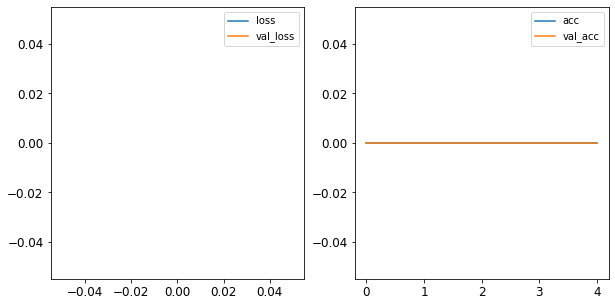

In [ ]:
plt.subplot(1,2,1)
plt.plot(rnnhistory.history["loss"])
plt.plot(rnnhistory.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(rnnhistory.history["accuracy"])
plt.plot(rnnhistory.history["val_accuracy"])
plt.legend(('acc','val_acc'))


plt.gcf().set_size_inches((10,5))
plt.show()

In [ ]:
rnnhistory.history

{'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0],
 'loss': [nan, nan, nan, nan, nan],
 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [nan, nan, nan, nan, nan]}

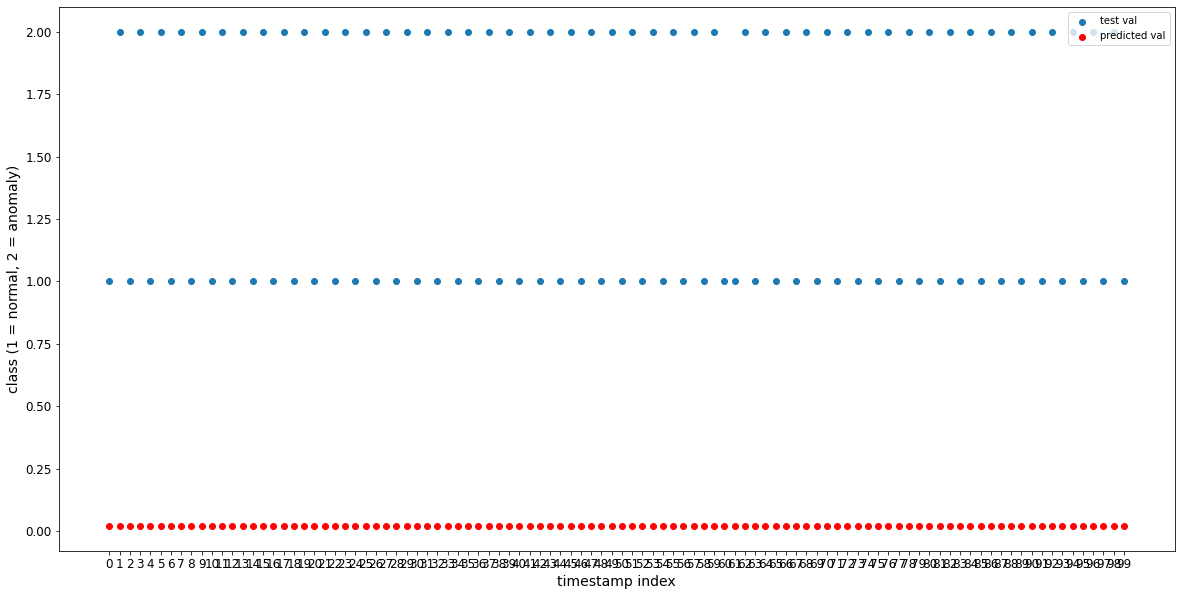

In [ ]:
plot_min=0
plot_max =100
plt.scatter(range(len(y_test[plot_min:plot_max])),y_test[plot_min:plot_max])
plt.scatter(range(plot_max-plot_min),[y_pred[i].argmax()+0.02 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
plt.legend(('test val','predicted val'))
plt.xlabel('timestamp index')
plt.ylabel('class (1 = normal, 2 = anomaly)')
plt.xticks(ticks=range(plot_min, plot_max))
plt.gcf().set_size_inches((20,10))
# plt.gcf().autofmt_xdate()
plt.show()

WE see that the LSTM based classifier provides results quite explainable to this evenly split dataset and the simplest 1 layer model gets a ~50% accuracy in just 5 epochs.
We now test this dataset by finetuning it on both the models trained on the passive-state/attack-free data.

# Impersonation attack Dataset

In [ ]:
impersonatedf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Impersonation_attack_dataset.csv')
impersonatedf['label'] = np.where(impersonatedf['CAN ID'] == 356,2,1) 
impersonatedf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,1.481193e+09,1415,0,8,0,0,0,0,0,0,0,1,1
1,1.481193e+09,790,0,8,5,28,106,10,28,19,0,127,1
2,1.481193e+09,399,0,8,0,33,28,0,0,67,0,0,1
3,1.481193e+09,608,0,8,5,28,0,48,255,147,99,53,1
4,1.481193e+09,128,0,8,0,23,106,10,28,19,28,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995467,1.481193e+09,1508,0,3,0,2,0,0,0,0,0,0,1
995468,1.481193e+09,339,0,8,0,128,16,255,0,255,160,46,1
995469,1.481193e+09,357,0,8,14,216,127,0,0,0,3,170,1
995470,1.481193e+09,544,0,8,244,3,247,3,12,0,58,16,1


### Train-test split

In [ ]:
impersonatedf.shape

(995472, 13)

In [ ]:
train_split = int(impersonatedf.shape[0]*0.7)
val_split = int(impersonatedf.shape[0]*0.1) + train_split
#test is val_split: 
train_split, val_split

(696830, 796377)

In [ ]:
series = impersonatedf.to_numpy()
series = series[ : , :, np.newaxis] 

In [ ]:
series.shape

(995472, 13, 1)

In [ ]:
n_features = series.shape[1]

X_train, y_train = series[:train_split, :n_features-1], series[:train_split, -1] # -1 references the last column
X_valid, y_valid = series[train_split:val_split, :n_features-1], series[train_split:val_split, -1]
X_test, y_test = series[val_split:, :n_features-1], series[val_split:, -1]


### Vanilla LSTM model 

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
rnnIMPmodel = keras.models.Sequential([
    keras.layers.LSTM(100,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='relu')
])
rnnIMPmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print(rnnIMPmodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
None


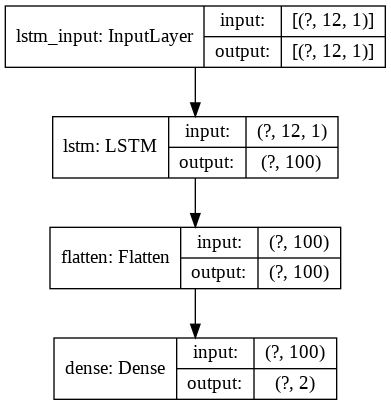

In [ ]:
tf.keras.utils.plot_model(rnnIMPmodel,show_shapes=True)

In [ ]:
rnnhistory = rnnIMPmodel.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=5, batch_size=1028)

Epoch 1/5
448/448 [==============================] - 3s 6ms/step - loss: 0.5058 - accuracy: 0.4878 - val_loss: 0.5066 - val_accuracy: 0.5079
Epoch 2/5
448/448 [==============================] - 2s 5ms/step - loss: 0.5141 - accuracy: 0.4868 - val_loss: 0.5049 - val_accuracy: 0.5079
Epoch 3/5
448/448 [==============================] - 2s 5ms/step - loss: 0.4921 - accuracy: 0.4868 - val_loss: 0.4676 - val_accuracy: 0.5079
Epoch 4/5
448/448 [==============================] - 2s 5ms/step - loss: 0.4756 - accuracy: 0.4868 - val_loss: 0.4676 - val_accuracy: 0.5079
Epoch 5/5
448/448 [==============================] - 2s 5ms/step - loss: 0.4754 - accuracy: 0.4868 - val_loss: 0.4674 - val_accuracy: 0.5079


### Evaluation and plotting

Here we evaluate the vanilla LSTM model on the test dataset and plot the error, evaluation and a subset of the predictions to try to interpret the output of the model corresponding to the dataset and hyperparameters.

In [ ]:
scores = rnnIMPmodel.evaluate(X_test,y_test)
print(f"Accuracy: {scores[1]}")

4104/4104 [==============================] - 10s 3ms/step - loss: 0.4772 - accuracy: 0.4864
Accuracy: 0.4863879084587097


In [ ]:
scores

[0.4742295742034912, 0.4863879084587097]

In [ ]:
y_pred = rnnIMPmodel.predict(X_test)

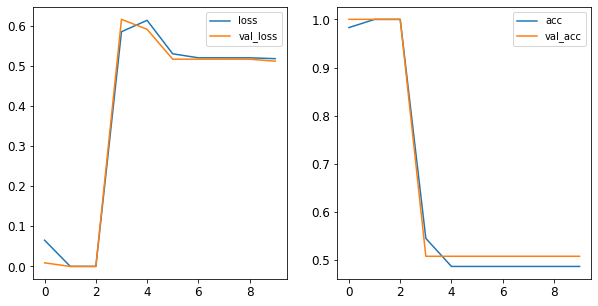

In [ ]:
plt.subplot(1,2,1)
plt.plot(rnnhistory.history["loss"])
plt.plot(rnnhistory.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(rnnhistory.history["accuracy"])
plt.plot(rnnhistory.history["val_accuracy"])
plt.legend(('acc','val_acc'))


plt.gcf().set_size_inches((10,5))
plt.show()

In [ ]:
rnnhistory.history

{'accuracy': [0.9828983545303345,
  0.9999760389328003,
  0.9999869465827942,
  0.5450963377952576,
  0.4867984354496002,
  0.4867984354496002,
  0.4867984354496002,
  0.4867984354496002,
  0.4867984354496002,
  0.4867984354496002],
 'loss': [0.06529616564512253,
  0.00019853905541822314,
  0.0001799893652787432,
  0.5845282673835754,
  0.6129899024963379,
  0.529574990272522,
  0.5196287631988525,
  0.5196101665496826,
  0.51960289478302,
  0.5174219608306885],
 'val_accuracy': [1.0,
  1.0,
  1.0,
  0.5079275369644165,
  0.5079275369644165,
  0.5079275369644165,
  0.5079275369644165,
  0.5079275369644165,
  0.5079275369644165,
  0.5079275369644165],
 'val_loss': [0.008958266116678715,
  2.9518807309614203e-07,
  3.7851489196327748e-06,
  0.6153626441955566,
  0.5906066298484802,
  0.5161788463592529,
  0.5161681771278381,
  0.5161576271057129,
  0.5161470770835876,
  0.5111324191093445]}

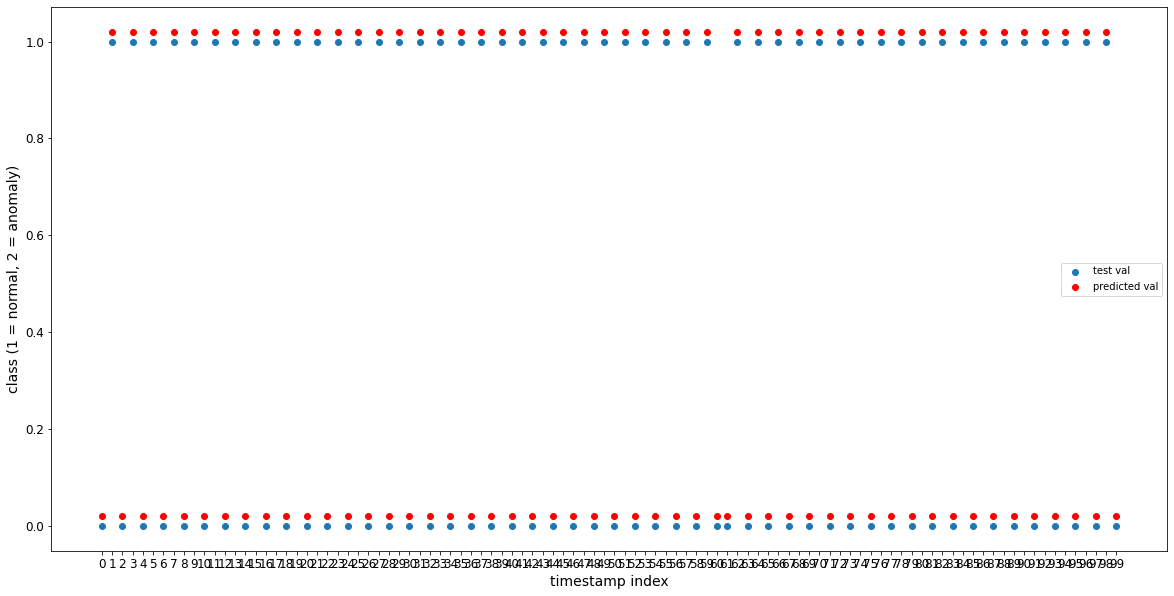

In [ ]:
plot_min=0
plot_max =60
plt.scatter(range(len(y_test[plot_min:plot_max])),y_test[plot_min:plot_max])
plt.scatter(range(plot_max-plot_min),[y_pred[i].argmax()+0.02 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
plt.legend(('test val','predicted val'))
plt.xlabel('timestamp index')
plt.ylabel('class (1 = normal, 2 = anomaly)')
plt.xticks(ticks=range(plot_min, plot_max))
plt.gcf().set_size_inches((20,10))
# plt.gcf().autofmt_xdate()
plt.show()

# Ablation study

**Dataset chosen for these experiments:** Impersonation Attack dataset, wherever it is not explicitly mentioned otherwise.

# Effect of Model Size and Layers

In this section we experiment with ranges of 4 values of different hyper parameters to see their effect on accuracy on the Impersonation Attack Dataset.

## Number of cells


## Activation function

## Learning Rate

# Effect of features

## Without timestamp feature

giving this byte data to the network, it is an interesting experiment to see what the effect is.

In [ ]:
newdf = df.drop(columns=['Timestamp'])
newdf

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,790,0,8,5,32,234,10,32,26,0,127,1
1,809,0,8,215,167,127,140,17,47,0,16,1
2,128,0,8,0,23,234,10,32,26,32,67,1
3,129,0,8,127,132,96,0,0,0,0,83,1
4,288,0,4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2369393,68,0,8,0,0,0,255,111,0,0,0,1
2369394,357,0,8,17,232,127,0,0,0,12,138,1
2369395,688,0,5,35,0,0,7,172,0,0,0,1
2369396,1200,0,8,0,0,0,0,0,0,0,0,1


In [ ]:
noTimestamp_series = newdf.to_numpy()
noTimestamp_series = noTimestamp_series[ : , :, np.newaxis] 

In [ ]:
n_features = noTimestamp_series.shape[1]
train_split = int(noTimestamp_series.shape[0]*0.8)
val_split = int(noTimestamp_series.shape[0]*0.1) + train_split
print(f'train split : {train_split}, val split: {val_split}')

X_train, y_train = noTimestamp_series[:train_split, :n_features-1], noTimestamp_series[:train_split, -1] # -1 references the last column
X_valid, y_valid = noTimestamp_series[train_split:val_split, :n_features-1], noTimestamp_series[train_split:val_split, -1]
X_test, y_test = noTimestamp_series[val_split:, :n_features-1], noTimestamp_series[val_split:, -1]


train split : 1895518, val split: 2132457


In [ ]:
X_train.shape, y_train.shape

((1895518, 11, 1), (1895518, 1))

In [ ]:
X_valid.shape,y_valid.shape

((236939, 11, 1), (236939, 1))

In [ ]:
X_test.shape, y_test.shape

((236941, 11, 1), (236941, 1))

In [ ]:
y_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
noTimestamp_series.shape, X_train.shape, y_train.shape

((2369398, 12, 1), (1895518, 11, 1), (1895518, 1))

In [ ]:
noTimestamp_rnnmodel = keras.models.Sequential([
    keras.layers.LSTM(100,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='relu')
])
noTimestamp_rnnmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print(noTimestamp_rnnmodel.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               40800     
_________________________________________________________________
flatten_9 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
noTimestamp_rnnhistory = noTimestamp_rnnmodel.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=5, batch_size=1028)

Epoch 1/5
1844/1844 [==============================] - 9s 5ms/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 1.2025e-07 - val_accuracy: 1.0000
Epoch 2/5
1844/1844 [==============================] - 9s 5ms/step - loss: 1.2025e-07 - accuracy: 1.0000 - val_loss: 1.2025e-07 - val_accuracy: 1.0000
Epoch 3/5
1844/1844 [==============================] - 9s 5ms/step - loss: 1.2025e-07 - accuracy: 1.0000 - val_loss: 1.2025e-07 - val_accuracy: 1.0000
Epoch 4/5
1844/1844 [==============================] - 9s 5ms/step - loss: 1.1974e-07 - accuracy: 1.0000 - val_loss: 1.1973e-07 - val_accuracy: 1.0000
Epoch 5/5
1844/1844 [==============================] - 9s 5ms/step - loss: 1.1968e-07 - accuracy: 1.0000 - val_loss: 1.1947e-07 - val_accuracy: 1.0000


In [ ]:
scores = noTimestamp_rnnmodel.evaluate(X_test,y_test)
print(f"Accuracy: {scores[1]}")

7405/7405 [==============================] - 16s 2ms/step - loss: 1.1947e-07 - accuracy: 1.0000
Accuracy: 1.0


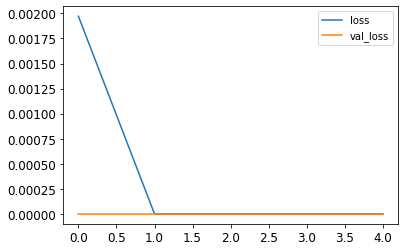

In [ ]:
plt.subplot(1,2,1)
plt.plot(noTimestamp_rnnhistory.history["loss"])
plt.plot(noTimestamp_rnnhistory.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(noTimestamp_rnnhistory.history["accuracy"])
plt.plot(noTimestamp_rnnhistory.history["val_accuracy"])
plt.legend(('acc','val_acc'))


plt.gcf().set_size_inches((10,5))
plt.show()

In [ ]:
y_pred = noTimestamp_rnnmodel.predict(X_test)
# plot_series(X_test[15, :, 0], y_test[15, 0], y_pred[15, 0])
# plt.show()

In [ ]:
predlist = np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))])
predlist = predlist.reshape((predlist.shape[0],1))
y_test.shape, y_pred.shape, predlist.shape

((236941, 1), (236941, 2), (236941, 1))

In [ ]:
compdf = pd.DataFrame(predlist)
compdf['real'] = y_test
compdf = compdf.rename(columns={0:'pred'})
compdf['right label'] = np.where(compdf['pred'] == compdf['real'],True, False)
compdf

,pred,real,right label
0,1,1,True
1,1,1,True
2,1,1,True
3,1,1,True
4,1,1,True
...,...,...,...
236936,1,1,True
236937,1,1,True
236938,1,1,True
236939,1,1,True


# Effect of Combining Datasets

## Attack-free + DoS datasets 
 Here we concatentate the Attack-Free and DoS Datasets to get one smooth, evenly biased and well distributed dataset to train and test on.

In [19]:
dosdf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/DoS_attack_dataset.csv')
dosdf['label'] = np.where(dosdf['CAN ID'] == 0,1,0)
dosdf = dosdf.drop(labels=['Timestamp'],axis=1)
dosdf

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0,0,8,0,0,0,0,0,0,0,0,1
1,128,0,8,0,23,220,9,22,17,22,187,0
2,0,0,8,0,0,0,0,0,0,0,0,1
3,129,0,8,64,132,135,0,0,0,0,107,0
4,0,0,8,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
656574,0,0,8,0,0,0,0,0,0,0,0,1
656575,129,0,8,64,132,137,0,0,0,0,240,0
656576,0,0,8,0,0,0,0,0,0,0,0,1
656577,399,0,8,0,59,24,0,0,63,0,0,0


In [20]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Attack_free_dataset.csv')
df['label'] = 0
df = df.drop(columns=['Timestamp'])
df

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,790,0,8,5,32,234,10,32,26,0,127,0
1,809,0,8,215,167,127,140,17,47,0,16,0
2,128,0,8,0,23,234,10,32,26,32,67,0
3,129,0,8,127,132,96,0,0,0,0,83,0
4,288,0,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2369393,68,0,8,0,0,0,255,111,0,0,0,0
2369394,357,0,8,17,232,127,0,0,0,12,138,0
2369395,688,0,5,35,0,0,7,172,0,0,0,0
2369396,1200,0,8,0,0,0,0,0,0,0,0,0


* Here we toss out the timestamp column as in this approach it is not informative about the nature of the outlier.
* It also helps us balance out the problems encountered in the previous attack-free and Dos attack experiments.

* in the attack free dataset - all the packets were normal data and so had to be labelled with only one value, training a model on single class data does not means it learns anything.

* in the Dos Attack experiment, every second message is a dos attack message, leaving the dataset evenly split 50:50 on anomalies/normal network data, but there is not enough contiguous network data for it to learn normal state nor attack state, and as a result it's accuracy is averaging around 50%

In [21]:
newdf = df.append(dosdf)
newdf

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,790,0,8,5,32,234,10,32,26,0,127,0
1,809,0,8,215,167,127,140,17,47,0,16,0
2,128,0,8,0,23,234,10,32,26,32,67,0
3,129,0,8,127,132,96,0,0,0,0,83,0
4,288,0,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
656574,0,0,8,0,0,0,0,0,0,0,0,1
656575,129,0,8,64,132,137,0,0,0,0,240,0
656576,0,0,8,0,0,0,0,0,0,0,0,1
656577,399,0,8,0,59,24,0,0,63,0,0,0


In [22]:
newdf.groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,2690353,2690353,2690353,2690353,2690353,2690353,2690353,2690353,2690353,2690353,2690353
1,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624


In [23]:
335624/2690353

0.1247509155861703

### Train-test-split



In [24]:
X_train=newdf.sample(frac=0.8,random_state=200) #random state is a seed value 200 
X_test=newdf.drop(X_train.index)
X_train

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
2326379,128,0,8,0,23,2,10,22,19,22,70,0
170303,339,0,8,0,128,16,255,0,255,144,30,0
1798599,1264,0,8,0,0,148,0,0,206,210,4,0
1729533,809,0,8,133,179,127,140,17,44,0,16,0
342650,898,0,8,64,254,15,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
612802,0,0,8,0,0,0,0,0,0,0,0,1
1269777,356,0,8,0,8,0,0,0,0,14,6,0
650992,544,0,8,237,3,251,3,12,0,60,16,0
467356,848,0,8,5,32,148,121,124,0,0,180,0


In [25]:
X_train.groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,2152549,2152549,2152549,2152549,2152549,2152549,2152549,2152549,2152549,2152549,2152549
1,268233,268233,268233,268233,268233,268233,268233,268233,268233,268233,268233


In [26]:
X_test.groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,380976,380976,380976,380976,380976,380976,380976,380976,380976,380976,380976
1,13446,13446,13446,13446,13446,13446,13446,13446,13446,13446,13446


In [27]:
13446/380976

0.035293561799168455

In [28]:
y_train = X_train.pop('label')
y_train

2326379    0
170303     0
1798599    0
1729533    0
342650     0
          ..
612802     1
1269777    0
650992     0
467356     0
1212228    0
Name: label, Length: 2420782, dtype: int64

In [29]:
y_test = X_test.pop('label')
y_test

28        0
67        0
106       0
111       0
133       0
         ..
656495    1
656502    0
656528    0
656531    0
656545    0
Name: label, Length: 394422, dtype: int64

In [30]:
def threedimensionalize(dataframe):
    tempdf = dataframe.to_numpy()
    if(len(dataframe.shape) == 2):
        return tempdf[:,:,np.newaxis]
    if(len(dataframe.shape) == 1):
        return tempdf[:,np.newaxis]

In [31]:
X_train = threedimensionalize(X_train)
y_train = threedimensionalize(y_train)
X_test = threedimensionalize(X_test)
y_test = threedimensionalize(y_test)

In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2420782, 11, 1), (2420782, 1), (394422, 11, 1), (394422, 1))

### Vanilla LSTM Model

In [33]:
rnnmodel = keras.models.Sequential([
    keras.layers.LSTM(100,input_shape=[X_train.shape[1],1]),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='relu')
])
rnnmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print(rnnmodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
None


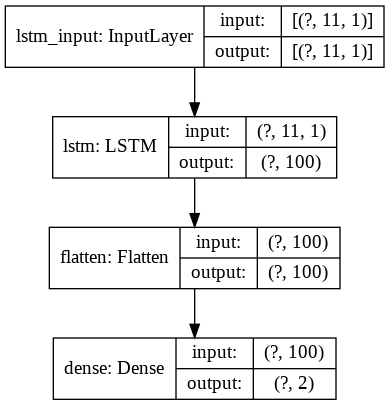

In [34]:
tf.keras.utils.plot_model(rnnmodel,show_shapes=True)

In [35]:
early_stop=keras.callbacks.EarlyStopping(monitor='loss',patience=10)

rnnhistory = rnnmodel.fit(X_train,y_train,
                          epochs=5,
                          batch_size=1028,
                          callbacks=[early_stop])

Epoch 1/5
2355/2355 [==============================] - 11s 5ms/step - loss: 0.1089 - accuracy: 0.8891
Epoch 2/5
2355/2355 [==============================] - 10s 4ms/step - loss: 0.0768 - accuracy: 0.8892
Epoch 3/5
2355/2355 [==============================] - 11s 5ms/step - loss: 0.0768 - accuracy: 0.8892
Epoch 4/5
2355/2355 [==============================] - 11s 5ms/step - loss: 0.0768 - accuracy: 0.8892
Epoch 5/5
2355/2355 [==============================] - 10s 4ms/step - loss: 0.0768 - accuracy: 0.8892


### Evaluation and plotting


In [36]:
scores = rnnmodel.evaluate(X_test,y_test)
print(f"Accuracy: {scores[1]}")

12326/12326 [==============================] - 27s 2ms/step - loss: 0.0236 - accuracy: 0.9659
Accuracy: 0.9659096002578735


## Bias Dataset Learning effect

this is perfectly explainable as the classifier only learning one class, the normal class and not the anomaly class as the proportion of normal to anomaly is 96.5 : 3.5 and that is exactly our accuracy. 

We try to solve this below by over sampling the dataset using SMOTE from sklearn in hopes of augmenting the dataset to balance it out better.

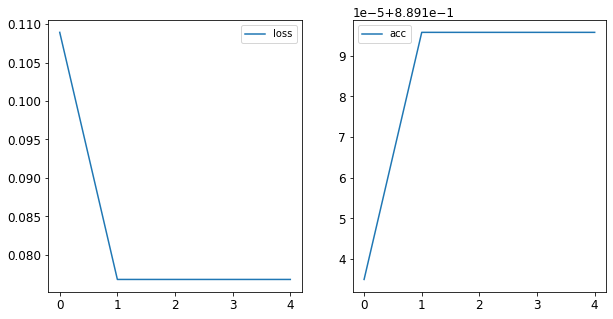

In [38]:
plt.subplot(1,2,1)
plt.plot(rnnhistory.history["loss"])
# plt.plot(rnnhistory.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(rnnhistory.history["accuracy"])
# plt.plot(rnnhistory.history["val_accuracy"])
plt.legend(('acc','val_acc'))

plt.gcf().set_size_inches((10,5))
plt.show()

In [39]:
y_pred = rnnmodel.predict(X_test)
y_pred

array([[1.7454925 , 0.        ],
       [1.4188201 , 0.        ],
       [1.53548   , 0.        ],
       ...,
       [1.2776093 , 0.        ],
       [0.29287118, 0.        ],
       [1.7911564 , 0.        ]], dtype=float32)

In [42]:
classes = [np.argmax(i) for i in y_pred]
classes

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [43]:
np.unique(classes)

array([0])

In [44]:
X_test[30],y_test[30], np.argmax(y_pred[30])

(array([[399],
        [  0],
        [  8],
        [  0],
        [ 41],
        [ 33],
        [  0],
        [  0],
        [ 69],
        [  0],
        [  0]]), array([0]), 0)

### Saving and Checking the size of the Model

In [ ]:
saved_model_dir = '/content/drive/MyDrive/Colab Notebooks/CS581/project-data/'
rnnmodel.save(saved_model_dir + "lstm-attackfree.h5",include_optimizer=False)
print(f"Saving Model to: {saved_model_dir}lstm-attackfree.h5")

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/lstm-attackfree.h5


In [ ]:
print(f'Size of the model without compression: {os.path.getsize(saved_model_dir + "lstm-attackfree.h5")/float(2**20)} Mb')

Size of the model without compression: 0.1733551025390625 Mb


### Oversampling the biased dataset for balanced anomaly-outlier classes


In [9]:
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [46]:
y_pred = rnnmodel.predict(X_test)
y_pred

array([[1.7454925 , 0.        ],
       [1.4188201 , 0.        ],
       [1.53548   , 0.        ],
       ...,
       [1.2776093 , 0.        ],
       [0.29287118, 0.        ],
       [1.7911564 , 0.        ]], dtype=float32)

In [47]:
classes = [np.argmax(i) for i in y_pred]
classes[:30]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [48]:
recall_score(y_test, classes)

0.0

In [49]:
y_pred = rnnmodel.predict(X_train)
classes = [np.argmax(i) for i in y_pred]
recall_score(y_train,classes)

0.0

In [ ]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

## Attack-free + Impersonation Dataset

## Attack-free + Impersonation + DoS datasets

# END